In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

In [22]:
# Load and prepare the data
file_path = "../data/df_restaurants_model.csv"
df_restaurants_model = pd.read_csv(file_path)

# Convert boolean columns to integers
df_restaurants_model = df_restaurants_model.astype({col: 'int' for col in df_restaurants_model.select_dtypes(include=['bool']).columns})

# Feature engineering: create interaction term
df_restaurants_model['delivery_drive_thru'] = df_restaurants_model['delivery'] * df_restaurants_model['drive_thru']
X = df_restaurants_model.drop(columns=['stars'])

# Safely drop columns that may not exist
columns_to_drop = ['appointment_only', 'coat_check', 'drive_thru', 'hours_weekend']
X_reduced = X.drop(columns=[col for col in columns_to_drop if col in X.columns])

y = df_restaurants_model['stars']

X_reduced.columns

Index(['delivery', 'alcohol', 'bike_parking', 'credit_card', 'caters', 'dogs',
       'good_for_kids', 'good_for_groups', 'happy_hour', 'tv',
       'outdoor_seating', 'price_range', 'reservations', 'table_service',
       'take_out', 'wheelchair', 'wifi', 'hours_per_week', 'open_on_weekend',
       'food_type_one_American', 'food_type_one_Barbeque',
       'food_type_one_Burgers', 'food_type_one_Cafes',
       'food_type_one_Cajun/Creole', 'food_type_one_Chicken Wings',
       'food_type_one_Chinese', 'food_type_one_Delis', 'food_type_one_Diners',
       'food_type_one_Greek', 'food_type_one_Indian', 'food_type_one_Italian',
       'food_type_one_Japanese', 'food_type_one_Mexican',
       'food_type_one_Sandwiches', 'food_type_one_Seafood',
       'food_type_one_Steakhouses', 'food_type_one_Thai',
       'food_type_one_Vietnamese', 'food_type_one_None', 'state_encoded',
       'delivery_drive_thru'],
      dtype='object')

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Create a pipeline for preprocessing
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocess the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [8]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [7],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'reg_alpha': [0],
    'reg_lambda': [10]
}

# Initialize XGBoost Regressor
xgb = XGBRegressor(random_state=42, eval_metric='rmse')

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  # Increased cross-validation for better robustness
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_c...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0.1],
                         'learning_rate': [0.05], 'max_depth': [7],
                         'n_estimators': [300], 'reg_alpha': [0],
                         'reg_lambda': [10], 'subsample': [0.8]},
             scoring='r2', verbose=1)

R-squared: 0.41499904417815814
                        Feature  Importance
0                hours_per_week      5775.0
1                 state_encoded      3323.0
2                   price_range      1129.0
3                      delivery       902.0
4                       alcohol       895.0
5                            tv       872.0
6               outdoor_seating       853.0
7                        caters       848.0
8               good_for_groups       779.0
9                  bike_parking       777.0
10                         wifi       772.0
11                good_for_kids       765.0
12                   wheelchair       721.0
13                     take_out       684.0
14                 reservations       679.0
15                table_service       647.0
16                  credit_card       621.0
17          delivery_drive_thru       458.0
18                   happy_hour       447.0
19       food_type_one_American       413.0
20     food_type_one_Sandwiches       338.0
2

<Figure size 1000x600 with 0 Axes>

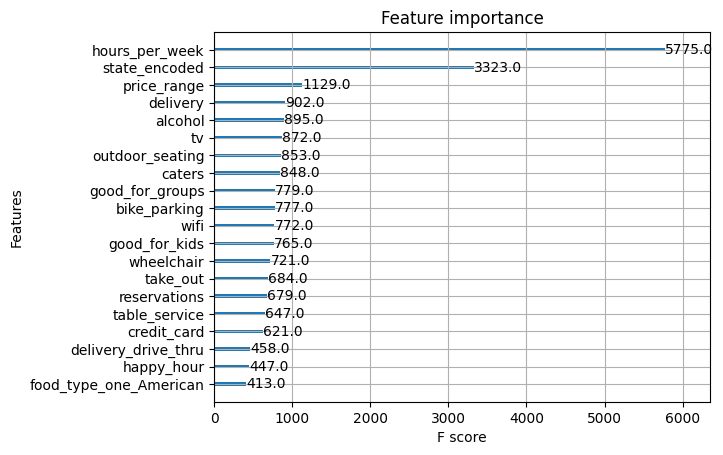

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost as xgb

# Use the best model from GridSearchCV directly without saving/loading
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_xgb_model.predict(X_test_processed)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Extract the Booster object from the XGBRegressor model
booster = best_xgb_model.get_booster()

# Map feature importance to the feature names (convert to a list)
booster.feature_names = X_train.columns.tolist()  # Ensure it's a list of feature names

# Get the feature importance values
importance_dict = booster.get_score(importance_type='weight')

# Convert the dictionary to a DataFrame for easier handling
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(importance_df)

# Now you can export or use the `importance_df` for building charts
# For example, saving it to CSV for use in PowerPoint or other tools
importance_df.to_csv("feature_importance.csv", index=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(booster, max_num_features=20)
plt.show()

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost as xgb

# Use the best model from GridSearchCV directly without saving/loading
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_xgb_model.predict(X_test_processed)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Extract the Booster object from the XGBRegressor model
booster = best_xgb_model.get_booster()

# Map feature importance to the feature names (convert to a list)
booster.feature_names = X_train.columns.tolist()  # Ensure it's a list of feature names

# Get the feature importance values
importance_dict = booster.get_score(importance_type='weight')

# Convert the dictionary to a DataFrame for easier handling
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Add the R-squared value to a new row at the top of the DataFrame
r2_df = pd.DataFrame([['R-squared', r2]], columns=['Feature', 'Importance'])
final_df = pd.concat([r2_df, importance_df], ignore_index=True)

# Save the DataFrame to an Excel file
output_file = "model_performance_and_importance.xlsx"
final_df.to_excel(output_file, index=False)

# Print confirmation
print(f"Results successfully exported to {output_file}")

R-squared: 0.41499904417815814
Results successfully exported to model_performance_and_importance.xlsx
